In [329]:
import pandas as pd
import numpy as np
import os
import sys
import librosa
import librosa.display
import numpy as np 
import matplotlib.pyplot as plt
# SVM
from sklearn import svm

import pickle
import joblib

import pyaudio
from six.moves import queue
import time
import wave

### CONST DATA

In [330]:
audio_feature = []
sound_sample = []

RATE = 44100
CHUNK = int(RATE / 10)  # 100ms

### Num to STR

In [331]:
def num_to_str(num):
    switcher = {
        0 :"air_conditioner",
        1 :"car_horn",
        2 :"children_playing",
        3 :"dog_bark",
        4 :"drilling",
        5 :"engine_idling",
        6 :"gun_shot",
        7 :"jackhammer",
        8 :"siren",
        9 :"street_music",
        }
    return switcher.get(num, "nothing")

### Draw Chart

In [332]:
FIG_SIZE = (15, 10)

def draw_chart(signal, sample_rate):
    plt.figure(figsize=FIG_SIZE)
    plt.xlabel("Time(s)")
    plt.ylabel("Amplitude")
    plt.title("Wave form")
    librosa.display.waveshow(signal, sample_rate, alpha = 0.4)
    
def draw_chart_half(signal, signal_spectrum):
    plt.figure(figsize=FIG_SIZE)
    plt.xlabel("Frequency")
    plt.ylabel("Magnitude")
    plt.title("Power Spectrum")
    plt.plot(signal, signal_spectrum, alpha=0.4)
    
    
def draw_chart_spectrogram(spectrogram, sample_rate, hop_length):
    plt.figure(figsize=FIG_SIZE)
    librosa.display.specshow(spectrogram, sr=sample_rate, hop_length=hop_length)
    plt.xlabel("Time")
    plt.ylabel("Frequency")
    plt.colorbar()
    plt.title("Spectrogram")
    
    
def draw_chart_log_spectrogram(log_spectrogram, sample_rate, hop_length):
    plt.figure(figsize=FIG_SIZE)
    librosa.display.specshow(log_spectrogram, sr=sample_rate, hop_length =hop_length)
    plt.xlabel("Time")
    plt.ylabel("Frequency")
    plt.colorbar(format="%+2.0f dB")
    plt.title("spectrogram * dB")
    
def draw_chart_mfccs(mfccs, signal, sample_rate, hop_length):
    plt.figure(figsize=FIG_SIZE)
    librosa.display.specshow(mfccs, sr=sample_rate, hop_length=hop_length)
    plt.xlabel("Time")
    plt.ylabel("MFCC Coefficients")
    plt.colorbar()
    plt.title("MFCCS")
    
def draw_chart_input_data(sound_sample):    
    plt.title("input sound")
    librosa.display.specshow(sound_sample[0]['mfccs'], x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()



### Feature Extractor

In [333]:
def Feature_Extract(input_audio, input_sample_rate): #44100, 4410
    num_mfccs = 50   
    
    try:
        audio, sample_rate = input_audio, input_sample_rate
        fft = np.fft.fft(audio)        
        signal_spectrum = np.abs(fft)
        n_fft = int(sample_rate * 0.025)
        hop_length = int(sample_rate * 0.01)
        
        frame_stride = float(hop_length)/sample_rate  #  0.01
        frame_length = float(n_fft)/sample_rate # 0.025
        
        stft = librosa.stft(audio, n_fft=n_fft, hop_length=hop_length)
        spectrogram = np.abs(stft)
        
        log_spectrogram = librosa.amplitude_to_db(spectrogram)
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, S=log_spectrogram, n_mfcc=num_mfccs)
        
        mfccs_pad = np.pad(mfccs, pad_width=((0, 0), (0, 0)), mode='constant')
        mfccsscaled = np.mean(mfccs.T,axis=0)
        
        draw_chart_log_spectrogram(log_spectrogram, sample_rate, hop_length)
        
    except Exception as e:
        #print("Error encountered while parsing file: ", input_audio)
        return None 
     
    return mfccs, mfccs_pad, mfccsscaled

### SVM Load

In [334]:
SVM = joblib.load('/home/park/coding/study/Sound/urban/Sound_classification_urbansound8k-master/model/svm')

### AUDIO PLOT

In [335]:
def plot_audio(audio_gen) :
    full_frame=[]
    for i, x in enumerate(audio_gen):
        # x=np.fromstring(x, np.int16)
        #print("audio gen : ", audio_gen)
        #print("i : ", i)
        #print("x : ", x)
        full_frame.append(x)
        #print("full_frame : ", full_frame)
        
        str_frame = b''.join(full_frame)
        #print("str_frame : ", str_frame)
        #wav = np.fromstring(str_frame, np.int16)
        wav = np.fromstring(str_frame, np.float32)
        
        #print("wav : ", wav) 
        
        plt.cla()
        plt.axis([0, CHUNK * 10, -1, 1])
        try:
            plt.plot(wav[-CHUNK * 10:])
        except:
            plt.plot(wav)
        plt.pause(0.01)

### AUDIO PREDICT

In [336]:
def show_predict(audio_gen):    
    full_frame=[]
    for i, x in enumerate(audio_gen):
        #x=np.fromstring(x, np.int16)
        full_frame.append(x)
        str_frame = b''.join(full_frame)
        #wav = np.fromstring(str_frame, np.float32)
        wav = np.frombuffer(str_frame, np.float32)
        audio_mfccs, audio_mfccs_pad, audio_mfccsscaled = Feature_Extract(wav, CHUNK)
        audio_feature.append([audio_mfccs, audio_mfccs_pad, audio_mfccsscaled])
        convert_audio_feature = pd.DataFrame(audio_feature, columns=['mfccs', 'mfccs_pad','feature'])
        #convert_audio_feature.to_pickle("convert_audio_feature.pkl")
        #convert_audio_feature = pd.read_pickle("convert_audio_feature.pkl")
        hop_length = int(CHUNK * 0.01)
        x_input = np.array(convert_audio_feature.feature.tolist())
        y_input = SVM.predict(x_input)
        print(num_to_str(y_input[0])) 

### MIC Stream

In [337]:
class MicrophoneStream(object):
    '''
    Magic Method
    1. __init__
    2. __enter__(self) : with 구문에 진입하는 시점에 자동으로 호출되는 메소드
    3. __exit__(self, type, value, traceback) : with 구문에서 빠져나오기 직전에 호출되는 메소드, type & value & traceback은 with문을 
                                                빠져 나오기 전 예외가 발생 했을 때의 정보를 나타낸다. 
    '''
    
    # 마이크 입력 클래스
    def __init__(self, rate, chunk): # 초기화
        self._rate = rate
        self._chunk = chunk 

        # 마이크 입력 버퍼
        self._buff = queue.Queue() # FIFO, 파라미터 maxsize 선언시 큐에 배치할 크기를 지정. 
                                   # 파라미터 maxsize 지정을 안할 시 무한의 크기를 갖는다.
        self.closed = True

    def __enter__(self):    
            
        #format = pyaudio.paInt16
        format = pyaudio.paFloat32
        
        rate = self._rate
        chunk = self._chunk
        call_back = self._fill_buffer
        
        self._audio_interface = pyaudio.PyAudio()
        # 오디오 스트림 생성
        self._audio_stream = self._audio_interface.open(
            channels=1, # Number of channels
            input=True, # 입력 스트림 여부, Default = False
            format=format, # Sampling Size & Portaudio Sample Format paFLoat32, paInt32, paInt24, paInt16, paUInt8, paCustomFormat             
            rate=rate, # Sampling Rate
            frames_per_buffer=chunk, # 버퍼당 프레임 수           
            stream_callback=call_back, # 콜백에 대한 정의 
                                       # (in_data, frame_count, time_info, status_flags) => Return tuple (out_data, flag)
                                       # out_data: Byte Array frame_out * channels * bytes-per-channel
                                       # flag: paContinue, paComplete or paAbort 
                                       # Stream Call back의 메인 Thread로 부터 호출된 분리된 Thread에서 동작한다. 
                                         # 1. 에러, 2. 메인 스레드로 부터 발생된 큐 예외처리, 3. 스트림 중단
        )
        '''
        확인 필요 
        1. Buffer 데이터 형태    
        2. Rate의 영향 
        3. Buffer 크기에 대한 영향     
        '''

        self.closed = False

        return self

    def __exit__(self, type, value, traceback):
        # _audio_stream - Pyaudio 스트림 객체, 스트림 종료
        self._audio_stream.stop_stream()
        self._audio_stream.close()
        self.closed = True
        
        # 종료된 스트림 데이터 버퍼 로드
        self._buff.put(None)
        
        # 종료 
        self._audio_interface.terminate()

    def _fill_buffer(self, in_data, frame_count, time_info, status_flags):
        self._buff.put(in_data) # 스트림 콜백으로 FIFO로 버퍼에 데이터 로드
        return None, pyaudio.paContinue

    def generator(self):
        while not self.closed:
            # Use a blocking get() to ensure there's at least one chunk of
            # data, and stop iteration if the chunk is None, indicating the
            # end of the audio stream.
            chunk = self._buff.get() # 버퍼로 부터 스트림 데이터 로드
            #print("chunk : ", chunk)
            if chunk is None:
                return
            data = [chunk] # 데이터 생성

            # Now consume whatever other data's still buffered.
            # Queue에 데이터가 없을 때 까지 append
            while True:
                try:
                    chunk = self._buff.get(block=False)
                    if chunk is None:
                        return
                    data.append(chunk)
                except queue.Empty:
                    break

            #print("data :", data)         
            
            yield b''.join(data) # .join은 리스틀르 문자열로 일정하게 합쳐준다. 
                                 #  data : [b'\xe9\xff\xf ...... ']의 형태로 저장된다.
            '''
            return은 list를 반환하고 yield는 제네레이터를 반환한다.
            파이썬에서 제너레이터는 여러개의 데이터를 미리 만들지 않고 필요 시 만든다.
            return의 경우 모든 결과에 대한 데이터를 메모리에 올려 놓아야 하지만 
            yield의 경우 필요한 결과 데이터 하나만 메모리에 올려 사용한다. 
            '''
            

### Save Wave

In [338]:
import pyaudio
import wave

chunk = 44100  # Record in chunks of 1024 samples
sample_format = pyaudio.paInt16  # 16 bits per sample
channels = 1
fs = 44100  # Record at 44100 samples per second
seconds = 5
filename = "output.wav"

p = pyaudio.PyAudio()  # Create an interface to PortAudio

print('Recording')

stream = p.open(format=sample_format,
                channels=channels,
                rate=fs,
                frames_per_buffer=chunk,
                input=True)

frames = []  # Initialize array to store frames

# Store data in chunks for 3 seconds
for i in range(0, int(fs / chunk * seconds)):
    data = stream.read(chunk)
    frames.append(data)

# Stop and close the stream 
stream.stop_stream()
stream.close()
# Terminate the PortAudio interface
p.terminate()

print('Finished recording')

# Save the recorded data as a WAV file
wf = wave.open(filename, 'wb')
wf.setnchannels(channels)
wf.setsampwidth(p.get_sample_size(sample_format))
wf.setframerate(fs)
wf.writeframes(b''.join(frames))
wf.close()



Recording
Finished recording


### wav classification

y_pred :  6


'\nlabel 0 : air_conditioner\nlabel 1 : car_horn\nlabel 2 : children_playing\nlabel 3 : dog_bark\nlabel 4 : drilling\nlabel 5 : engine_idling\nlabel 6 : gun_shot\nlabel 7 : jackhammer\nlabel 8 : siren\nlabel 9 : street_music\n'

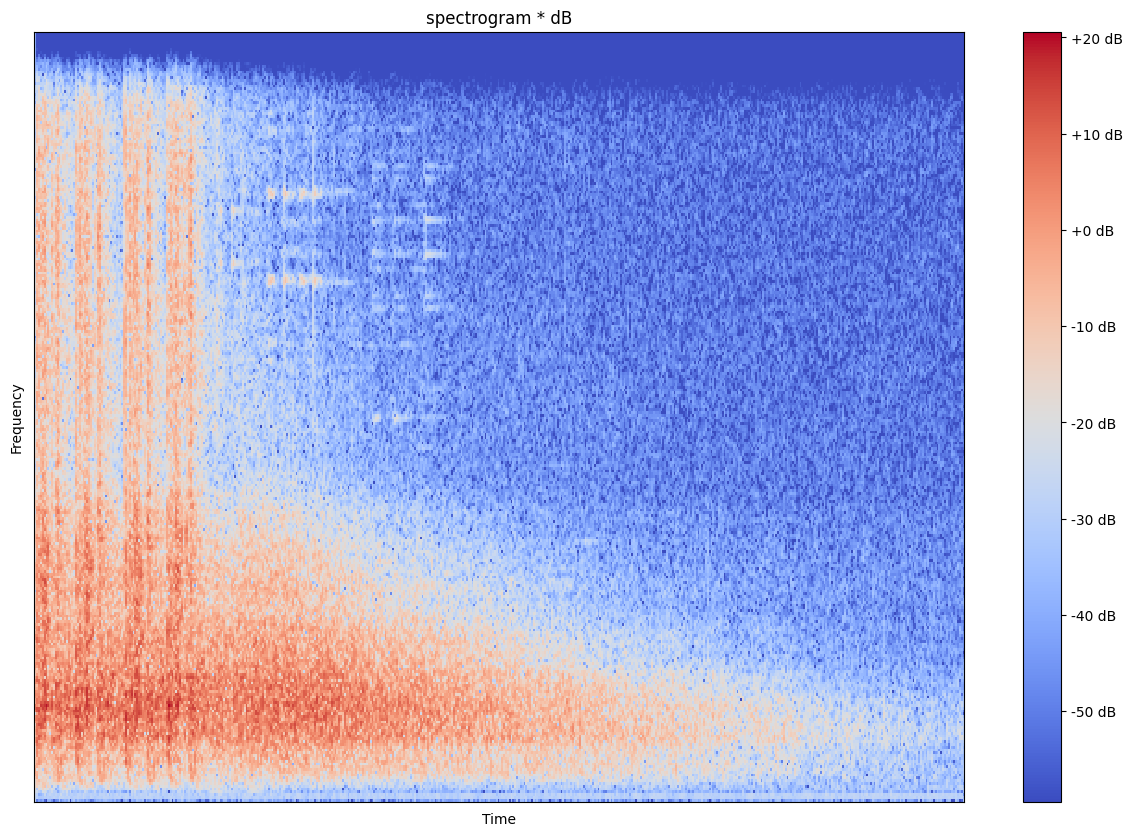

In [339]:
# wav file load 
import librosa
input_audio_feature = []
input_sound_sample = []

def file_select(num_of_fold):
    FOLD_PATH = "/home/park/coding/study/Sound/urban/Sound_classification_urbansound8k-master/test_fold/output.wav"
    #FOLD_PATH = "/home/park/coding/study/Sound/urban/UrbanSound8K/audio/test"
    FILE_NAME = FOLD_PATH + str(num_of_fold) + "/air.wav"
    #return FILE_NAME
    return FOLD_PATH

input_file_name = file_select(1)

#pre_extract_feature
input_signal, input_sample_rate = librosa.load(input_file_name) #7061-6-0-0.wav file
input_mfccs, input_mfccs_pad, input_mfccsscaled = Feature_Extract(input_signal, input_sample_rate)
input_audio_feature.append([input_mfccs, input_mfccs_pad, input_mfccsscaled])


input_audio_feature = pd.DataFrame(input_audio_feature, columns=['mfccs', 'mfccs_pad','feature'])

input_audio_feature.to_pickle("input_audio_feature.pkl")

# read the variables
input_audio_feature = pd.read_pickle("input_audio_feature.pkl")

hop_length = int(input_sample_rate * 0.01)

#draw_chart_mfccs(mfccs, input_signal, input_sample_rate, hop_length)

x_input = np.array(input_audio_feature.feature.tolist())


y_input = SVM.predict(x_input)
print("y_pred : ",y_input[0])

#input_accu = SVM.score(x_input, y_input)
#print('input Accuracy:', input_accu)

'''
label 0 : air_conditioner
label 1 : car_horn
label 2 : children_playing
label 3 : dog_bark
label 4 : drilling
label 5 : engine_idling
label 6 : gun_shot
label 7 : jackhammer
label 8 : siren
label 9 : street_music
'''



### Main

In [340]:
'''
while True:
    
    plt.ion()
    with MicrophoneStream(RATE, CHUNK) as stream:
        audio_generator = stream.generator()
        #print("audio_generator : ", audio_generator)
        #plot_audio(audio_generator)
        show_predict(audio_generator)
        #print(list(audio_generator))
'''

'\nwhile True:\n    \n    plt.ion()\n    with MicrophoneStream(RATE, CHUNK) as stream:\n        audio_generator = stream.generator()\n        #print("audio_generator : ", audio_generator)\n        #plot_audio(audio_generator)\n        show_predict(audio_generator)\n        #print(list(audio_generator))\n'